In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"naaggss","key":"b5cbe6ff53d89b33bf5b29be46653771"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ktaebum/anime-sketch-colorization-pair

100% 11.6G/11.6G [05:18<00:00, 46.3MB/s]
100% 11.6G/11.6G [05:18<00:00, 39.2MB/s]


In [ ]:
"""
Extracting the data from compressed zip file.
"""
Archive('./anime-sketch-colorization-pair.zip').extractall('.')

In [ ]:
!rm -rf /content/data/data

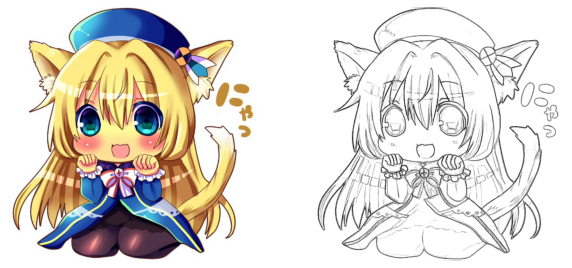

/content/data/train/1600124.png


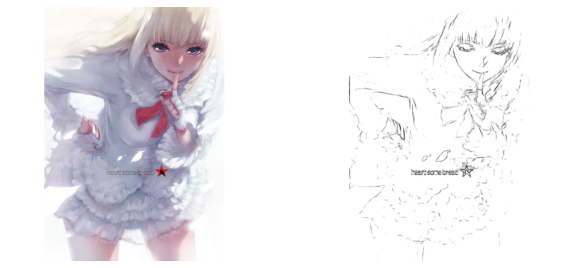

/content/data/train/2215126.png


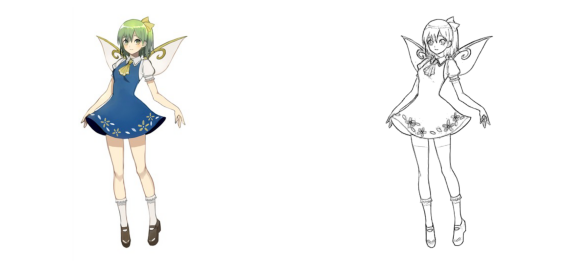

/content/data/train/2424087.png


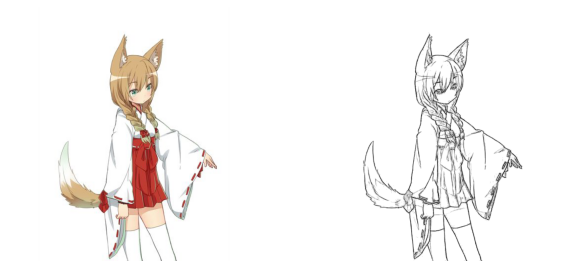

/content/data/train/2392148.png


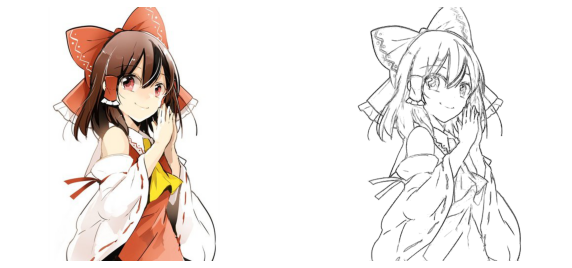

/content/data/train/2462111.png
mkdir: cannot create directory ‘trainData’: File exists
mkdir: cannot create directory ‘trainData/Images’: File exists


14224it [18:20, 12.93it/s]


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import numpy as np
import glob


#Displaying the sample sketch and color images.

for file in glob.glob('/content/data/train/*.png')[:5]:
    f, a = plt.subplots(1,2, figsize=(10,5))
    a = a.flatten()
    
    img = Image.open(file).convert('RGB')
    a[0].imshow(img.crop((0, 0, 512,512))); a[0].axis('off');
    a[1].imshow(img.crop((512, 0, 1024, 512))); a[1].axis('off');
    
    plt.show()
    print(file)

#Creating a directory for training data. 

get_ipython().system('mkdir trainData')
get_ipython().system('mkdir trainData/Images')
get_ipython().system('mkdir trainData/Sketches')

#Preprocessing and saving the training data to corresponding directory. 

for idx, file in tqdm(enumerate(glob.glob('/content/data/train/*.png'))):
    img = Image.open(file).convert('RGB')
    
    img.crop((0, 0, 512,512)).save('./trainData/Images/{}.png'.format(idx))
    img.crop((512, 0, 1024, 512)).save('./trainData/Sketches/{}.png'.format(idx))



In [ ]:
!rm -rf /content/data/train

In [ ]:
get_ipython().system('mkdir valData')

get_ipython().system('mkdir valData/Images')

get_ipython().system('mkdir valData/Sketches')





#Preprocessing and saving the validation/test data to corresponding directory. 

for idx, file in tqdm(enumerate(glob.glob('/content/data/val/*.png'))):
    img = Image.open(file).convert('RGB')
    
    img.crop((0, 0, 512,512)).save('./valData/Images/{}.png'.format(idx))
    img.crop((512, 0, 1024, 512)).save('./valData/Sketches/{}.png'.format(idx))

3545it [04:30, 13.09it/s]


In [ ]:
!rm -rf /content/data/val

In [ ]:
!pip install pyunpack

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
from tensorflow.keras.layers import Conv2DTranspose, Conv2D, Dense, Input, BatchNormalization, Dropout
from tensorflow.keras.layers import ReLU, LeakyReLU, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.activations import tanh, sigmoid
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras import Model
import tensorflow as tf

import matplotlib.pyplot as plt
from google.colab import files
from datetime import datetime
from pyunpack import Archive
from IPython import display
from PIL import Image
import numpy as np
import imageio
import random
import glob
import math

"""
Setting GPU growth configuration so as to avoid memory leaks
""" 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = .23

"""
Setting the seed for all random generators
""" 
rand_seed = random.randint(0, 2 ** 31 - 1)

tf.set_random_seed(rand_seed)
np.random.seed(rand_seed)
random.seed(rand_seed)

(512, 512)


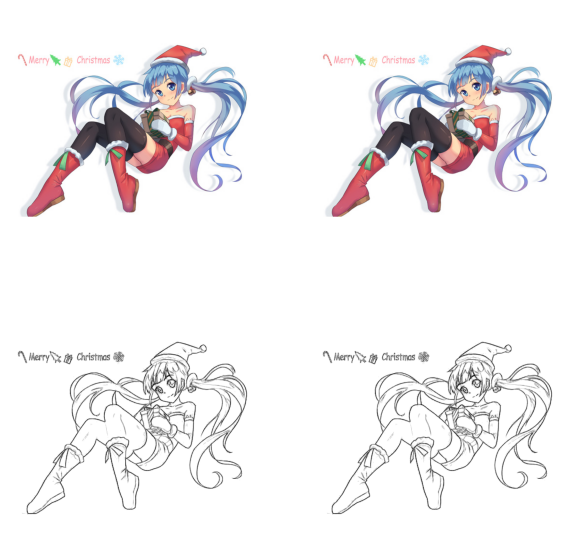

In [ ]:

#Displaying the sample sketches and color images.

img = Image.open('/content/trainData/Images/235.png').convert('RGB')
img2 = Image.open('/content/trainData/Sketches/235.png').convert('RGB')

print(img.size)

f,a = plt.subplots(2, 2, figsize=(10,10))
a = a.flatten()

for ax, i in zip(a, [img, img.resize((512, 512), Image.LANCZOS), img2, img2.resize((512, 512), Image.LANCZOS)]):
  ax.imshow(i)
  ax.axis('off')

plt.subplots_adjust(wspace=.2, hspace=.2)
plt.show()

In [ ]:
def convBlock(inp, n_filters, filter_size=4, stride=2, dropout=False, activation=True, BN=True, padding='same', alpha=.2):
 

  y = Conv2D(n_filters, filter_size, stride, padding, kernel_initializer=tf.keras.initializers.truncated_normal(stddev=.02))(inp)

  if BN:
    y = BatchNormalization()(y)

  if activation:
    y = LeakyReLU(alpha=alpha)(y)

  print(y.shape)
  return y

def convTransBlock(inp, n_filters, filter_size=4, stride=2, convOut=None, dropout=False, activation=True, BN=True, padding='same', alpha=.2):
 
  
  y = Conv2DTranspose(n_filters, filter_size, stride, padding,\
                      kernel_initializer=tf.keras.initializers.truncated_normal(stddev=.02))(concatenate([inp, convOut]) if convOut is not None else inp)

  if BN:
    y = BatchNormalization()(y)

  if dropout:
    y = Dropout(rate=dropout)(y)
  
  if activation:
    y = LeakyReLU(alpha=alpha)(y)

  print(y.shape)
  return y

In [ ]:
def generator(drop_rate, alpha, inp_shape=(512, 512, 3)):
  
  
  n_filters = 16
  
  inp = Input(inp_shape)

  print('Encoder:')
  conv1 = convBlock(inp, n_filters, BN=False, alpha=alpha) # 256x256
  conv2 = convBlock(conv1, n_filters*2, alpha=alpha)      # 128x128
  conv3 = convBlock(conv2, n_filters*4, alpha=alpha)      # 64x64
  conv4 = convBlock(conv3, n_filters*8, alpha=alpha)      # 32x32
  conv5 = convBlock(conv4, n_filters*8, alpha=alpha)      # 16x16
  conv6 = convBlock(conv5, n_filters*8, alpha=alpha)      # 8x8
  conv7 = convBlock(conv6, n_filters*8, alpha=alpha)      # 4x4
  conv8 = convBlock(conv7, n_filters*8, alpha=alpha)      # 2x2x512

  print('Decoder:')
  deconv1 = convTransBlock(conv8, n_filters*8, alpha=alpha)                                     # 4x4
  deconv2 = convTransBlock(deconv1, n_filters*8, convOut=conv7, dropout=drop_rate, alpha=alpha) # 8x8
  deconv3 = convTransBlock(deconv2, n_filters*8, convOut=conv6, dropout=drop_rate, alpha=alpha) # 16x16
  deconv4 = convTransBlock(deconv3, n_filters*8, convOut=conv5, dropout=drop_rate, alpha=alpha) # 32x32
  deconv5 = convTransBlock(deconv4, n_filters*4, convOut=conv4, alpha=alpha)                    # 64x64
  deconv6 = convTransBlock(deconv5, n_filters*2, convOut=conv3, alpha=alpha)                    # 128x128
  deconv7 = convTransBlock(deconv6, n_filters, convOut=conv2, alpha=alpha)                      # 256x256
  deconv8 = convTransBlock(deconv7, 3, convOut=conv1, activation=False, BN=False)  # 512x512

  outp = tanh(deconv8)

  model = Model(inputs=inp, outputs=outp)

  return model

In [ ]:
def discriminator(alpha, learning_rate, inp_shape=(512, 512, 3), target_shape=(512, 512, 3)):
 
  
  n_filters = 16
  
  inp1 = Input(inp_shape) # sketch input
  inp2 = Input(target_shape) # colored input

  inp = concatenate([inp1, inp2]) # 512x512x6

  conv1 = convBlock(inp, n_filters, BN=False, alpha=alpha) # 256x256x64
  conv2 = convBlock(conv1, n_filters*2, alpha=alpha) # 128x128x128
  conv3 = convBlock(conv2, n_filters*4, alpha=alpha) # 64x64x256
  conv4 = convBlock(conv3, n_filters*8, alpha=alpha) # 32x32x512
  conv5 = convBlock(conv4, n_filters*8, filter_size=2, stride=1, padding='valid', alpha=alpha) # 31x31x512
  conv6 = convBlock(conv5, n_filters=1, filter_size=2, stride=1, activation=False, BN=False, padding='valid') # 30x30x1

  sigmoid_outp = sigmoid(conv6)
  
  outp = GlobalAveragePooling2D()(sigmoid_outp)

  model = Model(inputs=[inp1, inp2], outputs=outp)

  opt = Adam(lr=learning_rate, beta_1=.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  
  return model

In [ ]:

#Downloading the VGG16 model for extracting basic features like edges, shapes.

from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16

vgg = VGG16(weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
553467904/553467096 [==============================] - 36s 0us/step


In [ ]:


def featureLevel_loss(y, g):
  

  def finalFLoss(y_true, y_pred):
    return K.mean( K.sqrt( K.sum( K.square( y - g ) ) ) )
  
  return finalFLoss

def totalVariation_loss(y, g):
  

  def finalTVLoss(y_true, y_pred):
    return K.abs( K.sqrt( K.sum(K.square(g[:, 1:, :, :] - g[:, :-1, :, :])) + K.sum(K.square(g[:, :, 1:, :] - g[:, :, :-1, :])) ) )
    
  return finalTVLoss

def pixelLevel_loss(y, g):
  

  def finalPLoss(y_true, y_pred):
    return K.mean( K.abs( y - g ) )
  
  return finalPLoss


def binaryCrossEntropy(from_logits=False):
  
  
  def finalBCELoss(y_true, y_pred):
    return  K.mean(K.binary_crossentropy(y_true, y_pred, from_logits=from_logits), axis=-1)
  
  return finalBCELoss

In [ ]:
K.resize_images(Input((512,512,3)), 224, 224, 'channels_last')

<tf.Tensor 'resize/ResizeNearestNeighbor:0' shape=(?, 114688, 114688, 3) dtype=float32>

In [ ]:
tf.image.resize(Input((512,512,3)), (224, 224), tf.image.ResizeMethod.NEAREST_NEIGHBOR)

<tf.Tensor 'resize_1/ResizeNearestNeighbor:0' shape=(?, 224, 224, 3) dtype=float32>

In [ ]:


vgg_net1 = Model(inputs=vgg.input, outputs=ReLU()(vgg.get_layer('block2_conv2').output))
vgg_net2 = Model(inputs=vgg.input, outputs=ReLU()(vgg.get_layer('block2_conv2').output))

def define_gan(g_model, d_model, vgg_net1, vgg_net2, learning_rate,\
               pixelLevelLoss_weight=100, totalVariationLoss_weight=.0001, featureLevelLoss_weight=.01,\
               inp_shape=(512, 512, 3)):

  
  d_model.trainable = False

  #Generator 
  sketch_inp = Input(inp_shape)
  gen_color_output = g_model([sketch_inp])
	
	#Discriminator 
  disc_outputs = d_model([sketch_inp, gen_color_output])
  color_inp = Input(inp_shape)
	
  #PixelLevel Loss
  pixelLevelLoss = pixelLevel_loss(color_inp, gen_color_output)
  
  #TotalVariation Loss
  totalVariationLoss = totalVariation_loss(color_inp, gen_color_output)

  #FeatureLevel Loss
 
  net1_outp = vgg_net1([tf.image.resize(color_inp, (224, 224), tf.image.ResizeMethod.BILINEAR)])
  
  net2_outp = vgg_net2([tf.image.resize(gen_color_output, (224, 224), tf.image.ResizeMethod.BILINEAR)])

  featureLevelLoss = featureLevel_loss(net1_outp,\
                                       net2_outp)
  
  #CrossEntropy Loss
  crossEntropyLoss = binaryCrossEntropy()
  
  #Final Model
  model = Model(inputs=[sketch_inp, color_inp], outputs=disc_outputs)
  
  opt = Adam(lr=learning_rate, beta_1=.5)
	

  model.compile(loss=lambda y_true, y_pred : tf.keras.losses.binary_crossentropy(y_true, y_pred) + \
                                             pixelLevelLoss_weight * pixelLevelLoss(y_true, y_pred) + \
                                             totalVariationLoss_weight * totalVariationLoss(y_true, y_pred) + \
                                             featureLevelLoss_weight * featureLevelLoss(y_true, y_pred),\
                optimizer=opt)
	
  return model

In [ ]:

#Creating the generator, discriminator and finally GAN using both.

g_model = generator(alpha=.2, drop_rate=.5)

d_model = discriminator(alpha=.2, learning_rate=.0002)

gan_model = define_gan(g_model, d_model, vgg_net1, vgg_net2, learning_rate=.0002,\
                       pixelLevelLoss_weight=100, totalVariationLoss_weight=.0001,\
                       featureLevelLoss_weight=.01)
gan_model.summary()

Encoder:
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
(?, 256, 256, 16)
(?, 128, 128, 32)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 16, 16, 128)
(?, 8, 8, 128)
(?, 4, 4, 128)
(?, 2, 2, 128)
Decoder:
(?, 4, 4, 128)
(?, 8, 8, 128)
(?, 16, 16, 128)
(?, 32, 32, 128)
(?, 64, 64, 64)
(?, 128, 128, 32)
(?, 256, 256, 16)
(?, 512, 512, 3)
(?, 256, 256, 16)
(?, 128, 128, 32)
(?, 64, 64, 64)
(?, 32, 32, 128)
(?, 31, 31, 128)
(?, 30, 30, 1)
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 512, 512, 3)  3408803     input_7[0][0]        

In [ ]:
!mkdir ./Sketch2Image/

In [ ]:
def save_plot(examples, epoch, n=3):
 

  n = int(math.sqrt(n))
  plt.figure(figsize=(6, 6))
  examples = (examples + 1) / 2.0
  for i in range(n * n):
    plt.subplot(n, n, 1 + i)
    plt.axis('off')
    plt.imshow(examples[i])
  
  filename = './Sketch2Image/generated_plot_e%03d.png' % (epoch+1)
  plt.savefig(filename)
  plt.show()

def summarize_performance(epoch, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, n_samples=9):


	X_real_sketches, X_real_images, y_real = generate_real_samples(sketch_paths, image_paths, n_samples)
	
	_, acc_real = d_model.evaluate([X_real_sketches, X_real_images], y_real, verbose=0)
	
	x_fake_sketches, x_fake_images, y_fake = generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, n_samples, seed_skets=seed_skets, seed_imgs=seed_imgs)
	
	_, acc_fake = d_model.evaluate([x_fake_sketches, x_fake_images], y_fake, verbose=0)
	
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	
	save_plot(x_fake_images, epoch, n_samples)

  # Saving the generator model after every epoch to get best epoch results later.
	filename = 'generator_model_%03d.h5' % (epoch+1)
	g_model.save(filename)

def generate_real_samples(sketch_paths, image_paths, n_samples, offset=None):
 

  ix = np.random.randint(0, TOTAL_IMAGES, n_samples)
  X_sketches = []
  X_images = []
  
  for sket, img in zip(sketch_paths[ix], image_paths[ix]):
    X_sketches.append(np.array(Image.open(sket).convert('RGB')))
    X_images.append(np.array(Image.open(img).convert('RGB')))
  
  # Normalizing the values to be between [-1, 1].
  X_sketches = (np.array(X_sketches, dtype='float32')-127.5)/127.5
  X_images = (np.array(X_images, dtype='float32')-127.5)/127.5
  y = np.ones((n_samples, 1))
	
  return X_sketches, X_images, y

def generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, n_samples, seed_skets=None, seed_imgs=None):
  X_sketches = []
  X_images = []

  if seed_skets is not None:
    
    X_images = g_model.predict(seed_skets)
    y = np.zeros((n_samples, 1))

    return seed_skets, X_images, y

  elif g_model is not None:

    ix = np.random.randint(0, TOTAL_IMAGES, n_samples)
    
    for sket in sketch_paths[ix]:
      X_sketches.append(np.array(Image.open(sket).convert('RGB')))
    
    X_sketches = (np.array(X_sketches, dtype='float32')-127.5)/127.5
    
    X_images = g_model.predict(X_sketches)
    y = np.zeros((n_samples, 1))
    
    return X_sketches, X_images, y
  
  else:
    
    ix = np.random.randint(0, TOTAL_IMAGES, n_samples)
    
    for sket, img in zip(sketch_paths[ix], image_paths[ix]):
      X_sketches.append(np.array(Image.open(sket).convert('RGB')))
      X_images.append(np.array(Image.open(img).convert('RGB')))
    
    X_sketches = (np.array(X_sketches, dtype='float32')-127.5)/127.5
    
    X_images = (np.array(X_images, dtype='float32')-127.5)/127.5
    y = np.zeros((n_samples, 1))

    return X_sketches, X_images, y

In [ ]:
def write_log(callback, name, loss, batch_no, flush=False):
   
    
    summary = tf.Summary()
    summary_value = summary.value.add()
    summary_value.tag = name
    summary_value.simple_value = loss
    callback.writer.add_summary(summary, batch_no)
    
    if flush:
      callback.writer.flush()

In [ ]:
def train(g_model, d_model, gan_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, output_frequency, n_epochs=100, n_batch=128, init_epoch=0):
 
  bat_per_epo = int(TOTAL_IMAGES / n_batch)
  half_batch = int(n_batch / 2)
  
  for i in range(init_epoch, n_epochs):
    start = datetime.now()
    gen_losses = []
    dis_losses = []
    
    for j in range(bat_per_epo):
      #Train discrimintor on real images
      if not j%2:
        X_real_skets, X_real_imgs, y_real = generate_real_samples(sketch_paths, image_paths, half_batch)
        
        d_loss1, _ = d_model.train_on_batch([X_real_skets, X_real_imgs], y_real * .9)


      if not j%3:
      #Train discrimintor on fake images
        X_fake_skets, X_fake_imgs, y_fake = generate_fake_samples(g_model, sketch_paths, image_paths, latent_dim, half_batch)

        d_loss2, _ = d_model.train_on_batch([X_fake_skets, X_fake_imgs], y_fake)

      d_loss = .5 * (d_loss1 + d_loss2)
      
      #Train generator on latent points
      X_gan_skets, X_gan_imgs, _ = generate_fake_samples(None, sketch_paths, image_paths, latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      
      g_loss = gan_model.train_on_batch([X_gan_skets, X_gan_imgs], y_gan)

      
      dis_losses.append(d_loss)
      gen_losses.append(g_loss)
      
      if not j % output_frequency:
        print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))

    
    # Save losses to Tensorboard after every epoch.
    write_log(tensorboard_disc_callback, 'discriminator_loss', np.mean(dis_losses), i+1, (i+1)%3==0)
    write_log(tensorboard_gen_callback, 'generator_loss', np.mean(gen_losses), i+1, (i+1)%3==0)
    
    # Displaying the summary after every epoch.
    display.clear_output(True)
    print('Time for epoch {} : {}'.format(i+1, datetime.now()-start))
    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
    summarize_performance(i, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, seed_skets.shape[0])
  
  display.clear_output(True)      
  print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
  summarize_performance(i, g_model, d_model, sketch_paths, image_paths, latent_dim, seed_skets, seed_imgs, seed_skets.shape[0])

In [ ]:

#Generating the paths for the black-and-white sketches and corresponding colored images.

img_paths = glob.glob('/content/trainData/Images/*.png')
sketch_paths = glob.glob('/content/trainData/Sketches/*.png')

img_paths.sort()
sketch_paths.sort()



img_paths = np.array(img_paths)
sketch_paths = np.array(sketch_paths)
global TOTAL_IMAGES
TOTAL_IMAGES = sketch_paths.shape[0]

In [ ]:

#Load the TensorBoard notebook extension.

%load_ext tensorboard

In [ ]:

#Clear any logs from previous runs.


!rm -rf ./logs/

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

#Tensorboard callbacks for logging generator and discriminator loss.


logdir_g_model = "logs/generator/" 
tensorboard_gen_callback = TensorBoard(log_dir=logdir_g_model)
tensorboard_gen_callback.set_model(g_model)

logdir_d_model = "logs/discriminator/"
tensorboard_disc_callback = TensorBoard(log_dir=logdir_d_model)
tensorboard_disc_callback.set_model(d_model)


#Launching the tensorboard.


# !kill 694
%tensorboard --logdir logs

NameError: ignored

In [ ]:
"""
View open TensorBoard instances.
"""
from tensorboard import notebook
notebook.list()

Known TensorBoard instances:
  - port 6006: logdir logs (started 0:02:14 ago; pid 1024)


>30, 1778/1778, d1=0.326, d2=0.001 g=138.188
>Accuracy real: 100%, fake: 11%


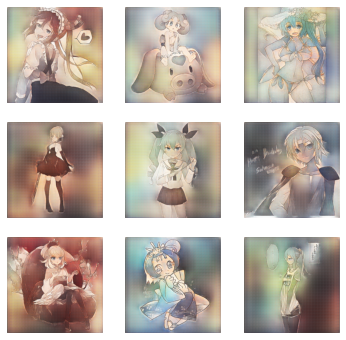

In [ ]:
#Seed sketches for checking progress after every epoch
seed_skets = []
seed_imgs = []
idxs = np.random.randint(0, TOTAL_IMAGES, 9)

for sket, img in zip(sketch_paths[idxs], img_paths[idxs]):
    seed_skets.append(np.array(Image.open(sket).convert('RGB')))
    seed_imgs.append(np.array(Image.open(img).convert('RGB')))

"""
Normalizing the values to be between [-1, 1].
""" 
seed_skets = (np.array(seed_skets, dtype='float32')-127.5)/127.5
seed_imgs = (np.array(seed_imgs, dtype='float32')-127.5)/127.5




train(g_model, d_model, gan_model, sketch_paths, img_paths, 100, seed_skets, seed_imgs, output_frequency=50, n_epochs=30, n_batch=8, init_epoch=0)


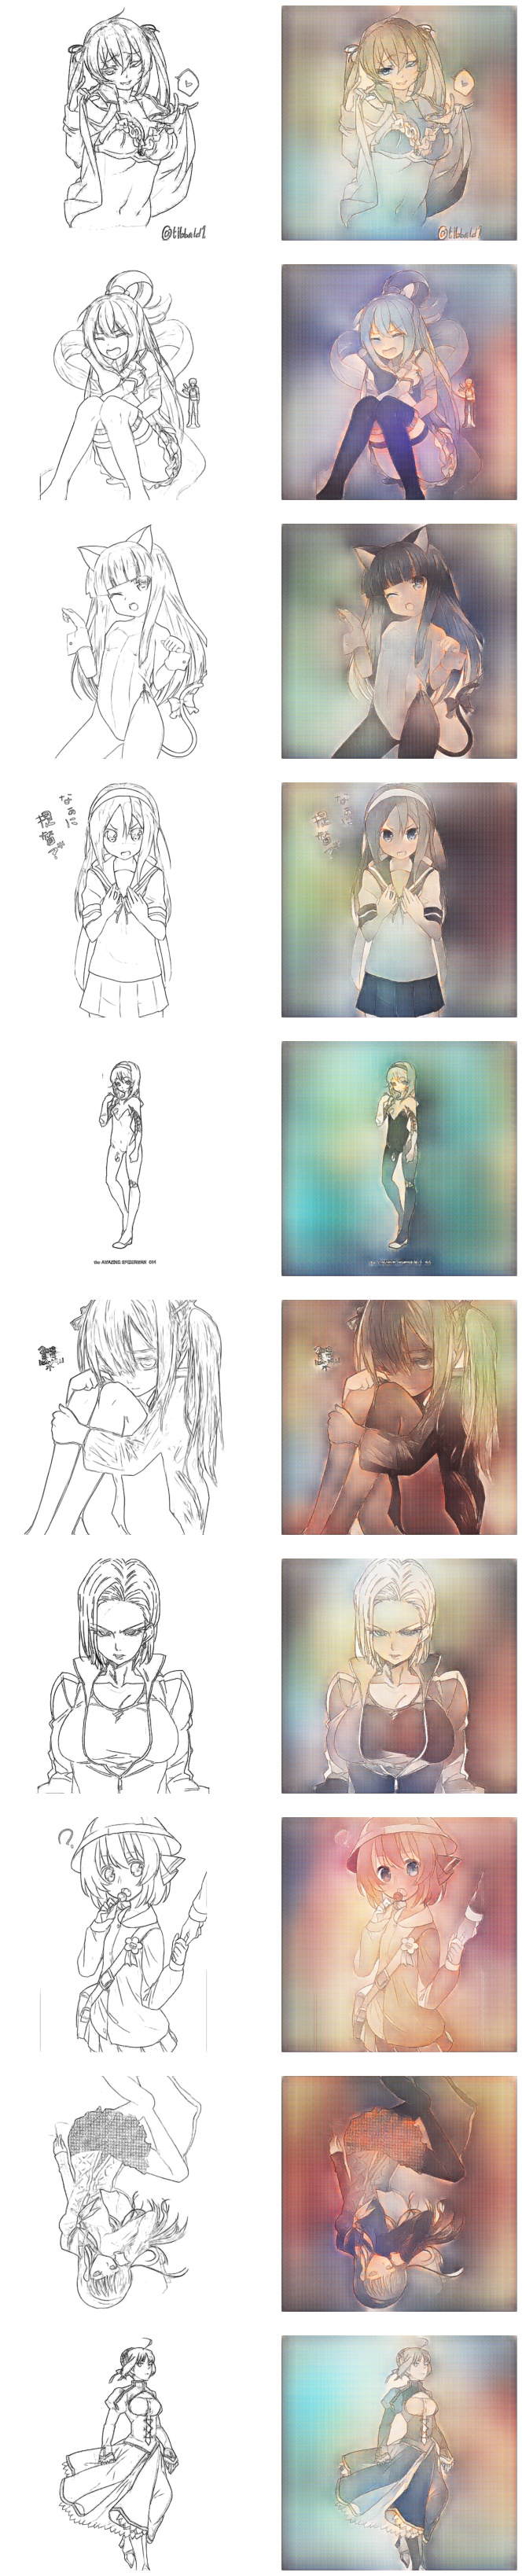

In [ ]:
k = 10

temp_skets = []
temp_imgs = []
idxs = np.random.randint(2335, TOTAL_IMAGES - 2335, k)

for sket, img in zip(sketch_paths[idxs], img_paths[idxs]):
    temp_skets.append(np.array(Image.open(sket).convert('RGB')))
    temp_imgs.append(np.array(Image.open(img).convert('RGB')))

temp_skets = np.array(temp_skets, dtype='float32')/127.5 - 1

pred = g_model.predict(temp_skets)
pred = (pred+1)/2.0
temp_skets = (temp_skets+1)/2.0

f, a = plt.subplots(k, 2, figsize=(12,60))
a = a.flatten()

idx = 0
for sket, pic in zip(temp_skets, pred):
  a[idx].imshow(sket)
  a[idx+1].imshow(pic)
  a[idx].axis('off')
  a[idx+1].axis('off')
  idx += 2

plt.subplots_adjust(wspace=.1, hspace=.1)
plt.show()

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('Sketch2Image/generated_plot_e*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**10000)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def saveModels(gan, generator, discriminator):
    discriminator.trainable = False
    save_model(gan, 'gan.h5')
    discriminator.trainable = True
    save_model(generator, 'generator.h5')
    save_model(discriminator, 'discriminator.h5')


def loadModels():
    discriminator = load_model('discriminator.h5')
    generator = load_model('generator.h5')
    gan = load_model('gan.h5')
    gan.summary()
    discriminator.summary()
    generator.summary()

    return gan, generator, discriminator

saveModels(gan_model, g_model, d_model)

In [ ]:
from google.colab import files

files.download('generator.h5')
files.download('gan.h5')
files.download('discriminator.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install pyunpack

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.models import save_model, load_model
import matplotlib.pyplot as plt
from pyunpack import Archive
import urllib.request
from PIL import Image
from tqdm import tqdm 
import numpy as np
import glob

In [ ]:
"""
Getting access to the google drive in colab for the dataset. 
"""
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
"""
Extracting the data from compressed zip file.
"""
Archive('drive/My Drive/Sketch2Image/AnimeTestData.zip').extractall('.')

Utils:

In [ ]:
def final_model(path):


  return load_model(path)

def predict(test_skets, generator):

  pred = generator.predict(test_skets)

  # Rescaling the generated color images and input sketches to the range [0, 255].
  pred = (pred+1)/2.0
  test_skets = (test_skets+1)/2.0

  # Displaying the generated color images from the generator.
  f, a = plt.subplots(test_skets.shape[0], 2,\
                      figsize=(.8 * test_skets.shape[0],\
                               5 * test_skets.shape[0]))
  a = a.flatten()
  idx = 0
  
  for sket, pic in zip(test_skets, pred):
    a[idx].imshow(sket); a[idx].axis('off')
    a[idx+1].imshow(pic); a[idx+1].axis('off')
    idx += 2

  plt.subplots_adjust(wspace=.1, hspace=.1)
  plt.show()

Generating the colored images for images not used in training and validation:

In [ ]:
"""
Generating the paths for the black-and-white sketches.
"""
sketch_paths = glob.glob('/content/trainData/Sketches/*.png')

sketch_paths = np.array(sketch_paths)

"""
Loading the random `K` test sketches into the memory.
"""
sketches = []

for sket in sketch_paths[:10]:
    sketches.append(np.array(Image.open(sket).convert('RGB')))

sketches = (np.array(sketches, dtype='float32')-127.5)/127.5

In [ ]:
generator = final_model(path='/content/generator_model_029.h5')

epoch 29 generator model on test sketches:

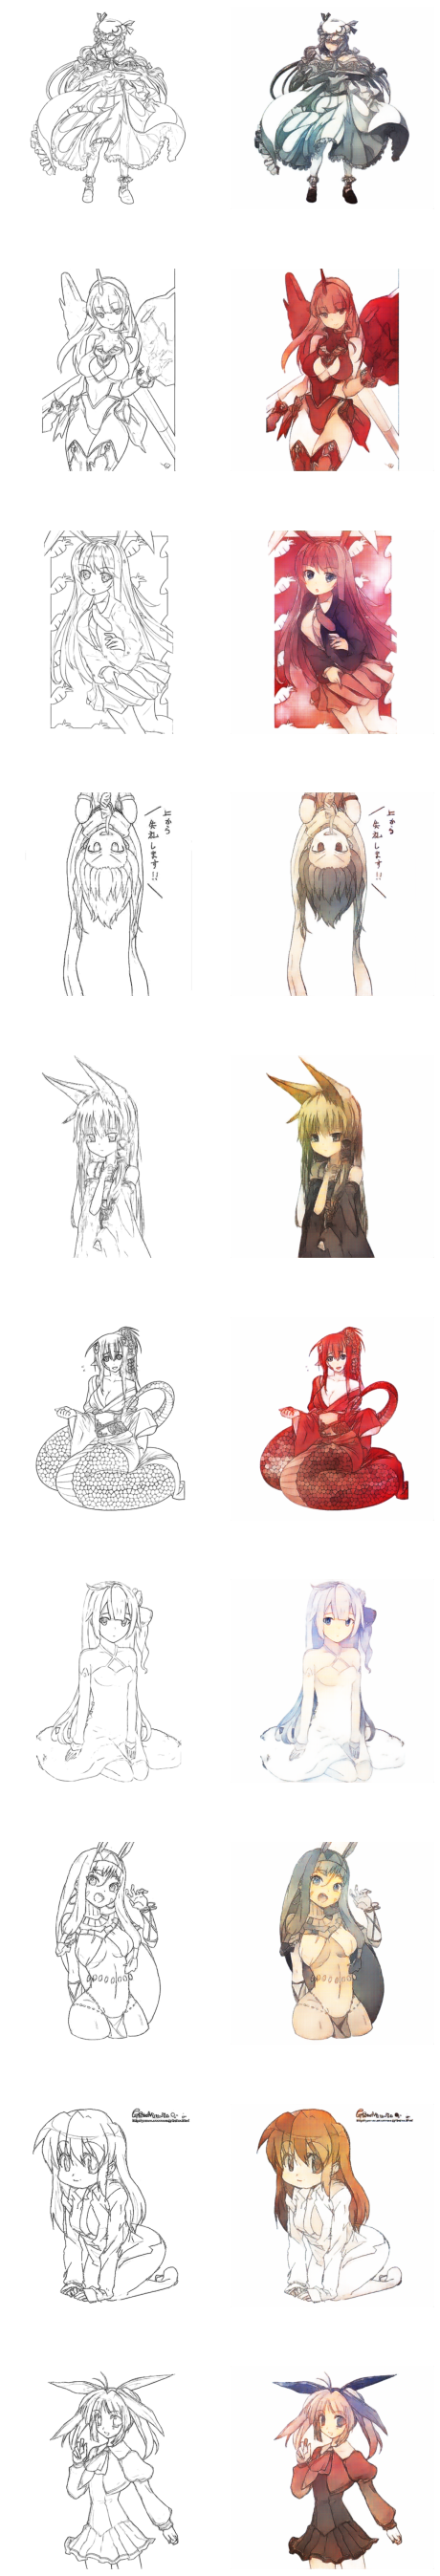

In [ ]:
predict(sketches, generator)

### Epoch 30 generator model on test sketches:

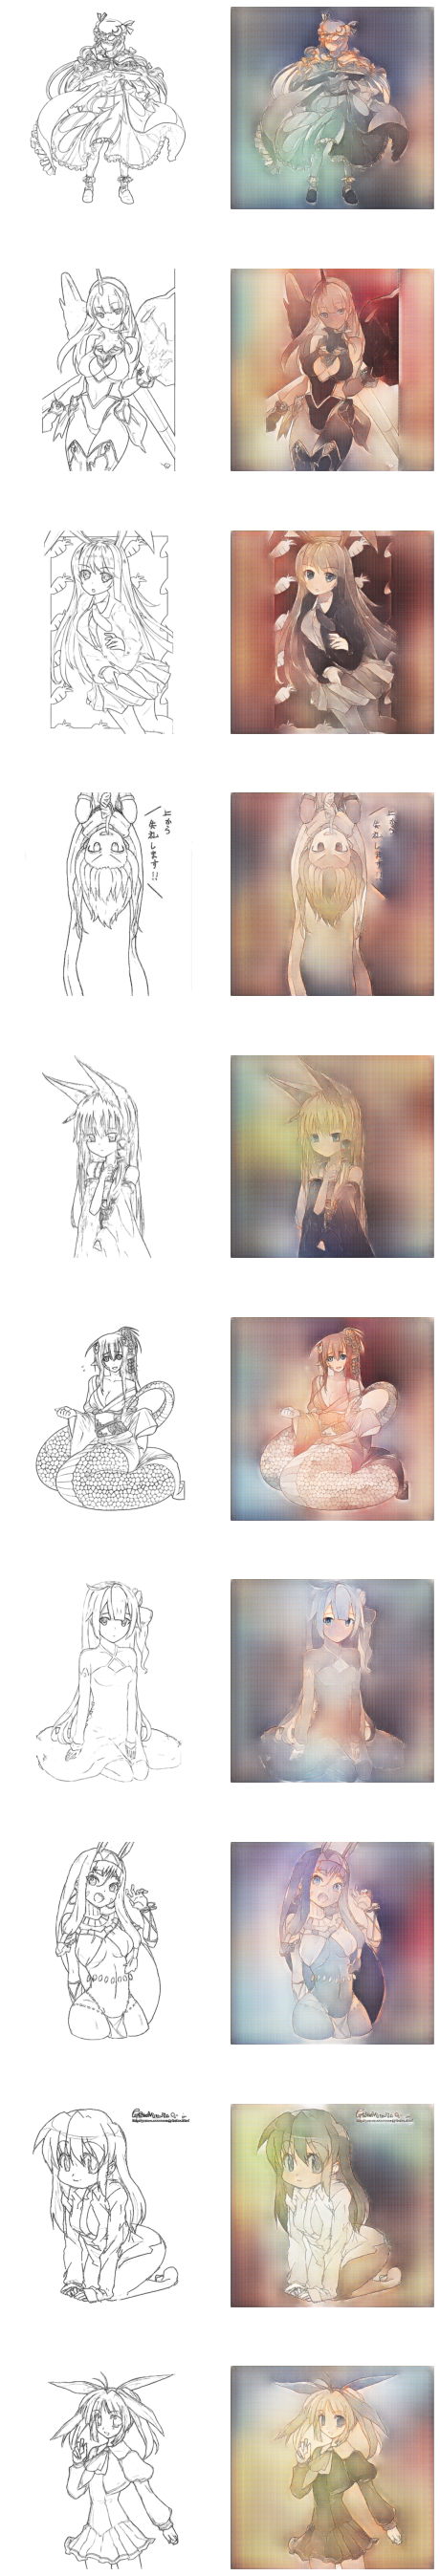

In [ ]:
generator = final_model(path='/content/generator_model_030.h5')

predict(sketches, generator)

## Pixel-wise accuracy and entropy on test sketches:

In [ ]:
!mkdir Images
!mkdir Sketches

In [ ]:
def pixelwise_accuracy(img_real, img_fake, thresh):
    
    img_real = (img_real + 1) / 2.
    img_fake = (img_fake + 1) / 2.

    diffR = np.absolute(np.round(img_real[..., 0]) - np.round(img_fake[..., 0]))
    diffG = np.absolute(np.round(img_real[..., 1]) - np.round(img_fake[..., 1]))
    diffB = np.absolute(np.round(img_real[..., 2]) - np.round(img_fake[..., 2]))

    # Check if the values lie within a threshold.
    predR = np.less_equal(diffR, 1 * thresh)
    predG = np.less_equal(diffG, 1 * thresh)
    predB = np.less_equal(diffB, 1 * thresh)

    # Mutilplying values across the channels.
    pred = predR * predG * predB

    return np.mean(pred)


def pixelwise_entropy(img_real, img_fake):
    
    img_real = (img_real + 1) / 2. 
    img_real /= 255.
    
    img_fake = (img_fake + 1) / 2.
    img_fake /= 255.

    target = np.less_equal(img_real, .5).astype(np.int)
    pred = - np.log(img_fake)

    channel_wise_entropy = np.mean(target * pred, axis=2)
    
    return np.mean(channel_wise_entropy)

In [ ]:
"""
Loading the generator model.
"""
g_model = final_model(path='/content/generator_model_029.h5')

"""
Generating the paths for test sketches.
"""
test_paths = np.array(glob.glob('data/val/*.png'))

In [ ]:
!rm -r Images/*
!rm -r Sketches/*

In [ ]:
"""
Preprocessing and saving the data to corresponding directory. 
"""
for idx, file in enumerate(test_paths[np.random.randint(0, test_paths.shape[0], 15)]):
    img = Image.open(file).convert('RGB')
    
    img.crop((0, 0, 512,512)).save('Images/{}.png'.format(idx))
    img.crop((512, 0, 1024, 512)).save('Sketches/{}.png'.format(idx))


"""
Generating the paths for the black-and-white sketches.
"""

In [ ]:

sketch_paths = glob.glob('/content/valData/Sketches/*.png')
img_paths = glob.glob('/content/valData/Images/*.png')

sketch_paths.sort()
img_paths.sort()

sketch_paths = np.array(sketch_paths)
img_paths = np.array(img_paths)

"""
Loading the random `K` test sketches into the memory.
"""
sketches = []
imgs = []

for sket, img in zip(sketch_paths[:20], img_paths[:30]):
    sketches.append(np.array(Image.open(sket).convert('RGB')))
    imgs.append(np.array(Image.open(img).convert('RGB')))

# Rescaling the generated color images and input sketches to the range [0, 255].
sketches = (np.array(sketches, dtype='float32')-127.5)/127.5
imgs = (np.array(imgs, dtype='float32')-127.5)/127.5

# Predicting the colors for the line-art anime.
gene_imgs = g_model.predict(sketches)

# Displaying the generated color images from the generator.
fig, axes = plt.subplots(sketches.shape[0], 2, figsize=(1.5 * sketches.shape[0], 6 * sketches.shape[0])); 
axes = axes.flatten(); # figsize ~ 23, 15

idx = 0 
for ind, (sk, im) in enumerate(zip(sketches, gene_imgs)):
  axes[idx].imshow( (sk + 1) / 2.)
  axes[idx].set_title('Input line-art sketch')
  axes[idx].axis('off')

  axes[idx+1].imshow( (im + 1) / 2.)
  axes[idx+1].set_title('\n'.join(['Pixel-wise entropy: {}'.format(np.round(pixelwise_entropy(imgs[ind], im), 2)),\
                          'Pixel-wise accuracy: {}%'.format(np.round(pixelwise_accuracy(imgs[ind], im, 0.05)*100., 2))]))
  axes[idx+1].axis('off')

  idx += 2
  
plt.subplots_adjust(wspace=.2, hspace=.2)
plt.show()

NameError: ignored

In [ ]:
from google.colab import files
files.download('/content/generator_model_029.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>